# Fast haze removal implementation

In this notebook, we will implement the method described in the article "Fast Haze Removal for a Single Remote Sensing Image Using Dark Channel Prior".

### Import of libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import rasterio
import os as os
from scipy.ndimage import gaussian_filter
import cv2

### Algotihtm implementation

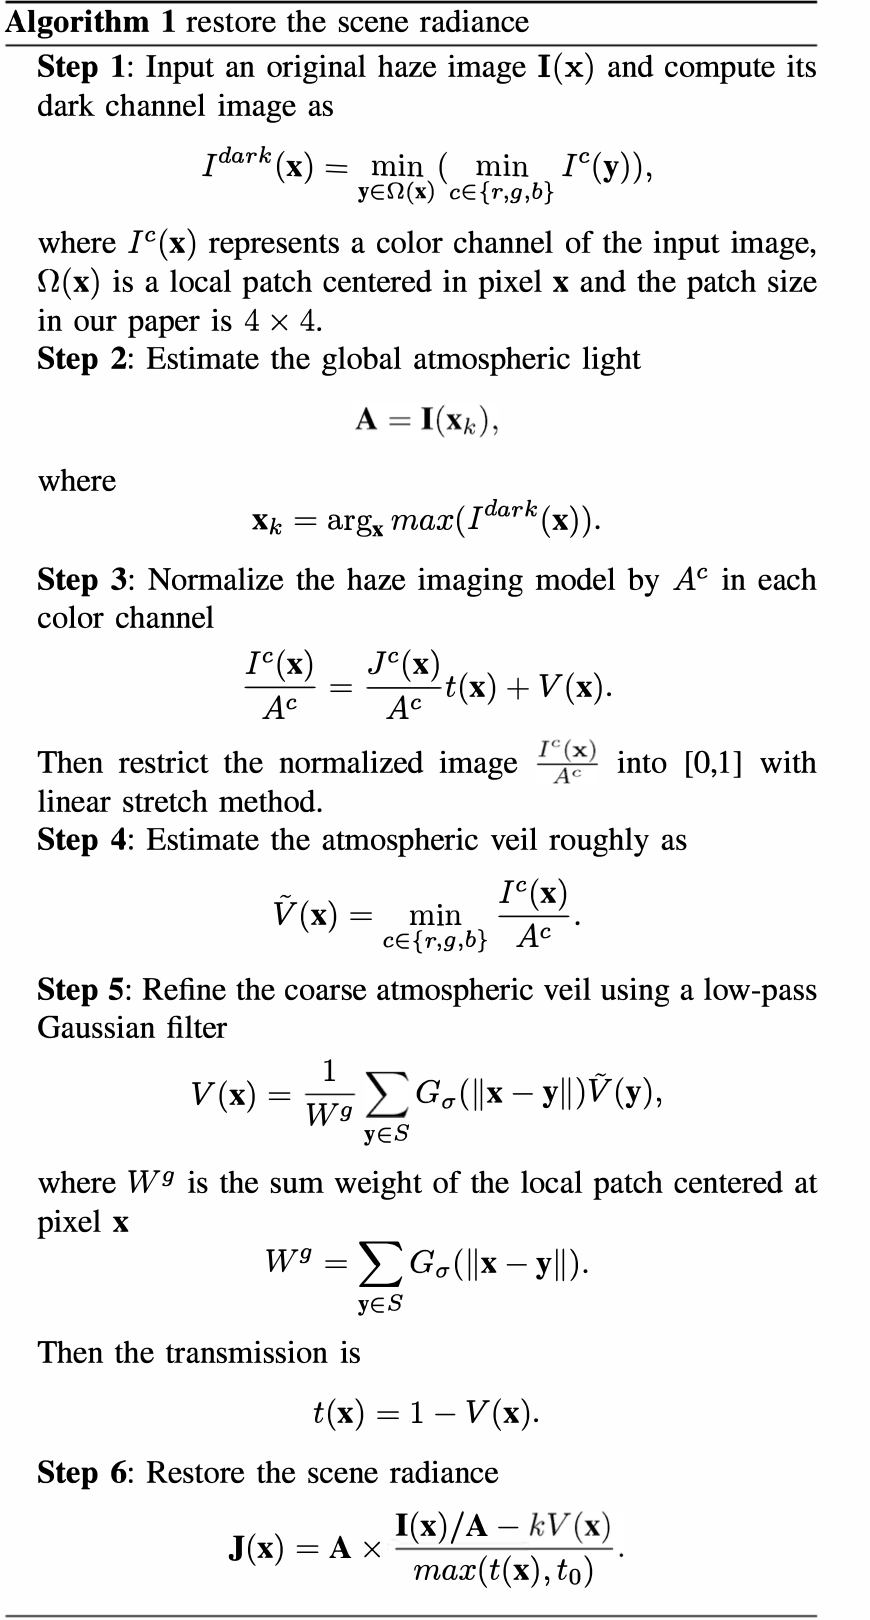

In [2]:
# Step 1
def dark_channel_prior(img, patch_size=4):
    """ Computes the dark channel of an image
    
    Inputs:
        img:           The input image
        patch_size:    The size of the neighborhood considered
                         
    Outputs: 
        img_dark       The dark image
    """

    h, w ,c = img.shape

    pad_img = np.array([np.pad(img[:,:,c], pad_width=patch_size) for c in range(img.shape[-1])])

    img_dark = np.zeros((h, w))
    
    for k in range(patch_size, h+patch_size):
        for j in range(patch_size, w+patch_size):
            
            img_dark[k-patch_size,j-patch_size] = np.nanmin(pad_img[: ,k-patch_size:k+patch_size+1, j-patch_size:j+patch_size+1])
    
    # Mask the dark channel so it has nans where original image has
    img_dark[np.isnan(img[:,:,0])] = np.nan

    return img_dark


# Step 2
def global_atmospheric_light(img, img_dark, patch_size=4):
    """ Computes the global atmospheric light of an image
        given its dark channel prior
    
    Inputs:
        img:           The input image
        img_dark:      The dark channel prior of the image
                         
    Outputs: 
        A              The global atmospheric light
    """

    xk = np.nanargmax(img_dark)
    xk = np.unravel_index(xk, img_dark.shape)

    # A = img[xk[1], xk[0]]
    A = img[xk]

    return A


# Step 3
def normalize(img, A):
    """ Normalizes the image by its global atmospheric light
        and stretches the values to [0,1]
    
    Inputs:
        img:           The input image
        A              The global atmospheric light
                         
    Outputs: 
        img_n          The image normalized by A and stretched to [0,1]
    """
    
    # Normalize by global atmospheric light
    img_n = img/A
    # Stretch to [0,1]
    img_n = img_n/np.nanmax(img_n, axis=(0,1))

    return img_n


# Steps 4 & 5
def atmospheric_veil(img_n, sigma=2):
    """ Estimates the atmospheric veil of the
        normalized image and smooths it

    Inputs:
        img_n:           The normalized image
                         
    Outputs: 
        V                The estimated atmospheric veil
    """ 
    
    V = np.nanmin(img_n, axis=2)
    V = gaussian_filter(V, sigma=sigma)
    V = np.expand_dims(V, axis=-1)

    return V

def transmission(V):
    t = 1 - V
    return t


# Step 6
def restore_radiance(img, A, V, t, t0=1, k=1):
    """ Restore scene radiance after haze removal

    Inputs:
        img:           The input image
        A:             The global atmospheric light
        V:             The estimated atmospheric veil
        t:             The estimated transmission
        t0:            Lower bound on transmission t
        k:             Parameter to keep a small amount of haze
                       from distant objects

    Outputs: 
        J              The restored scene radiance
    """ 
    
    J = A*((img/A) - k*V)/np.maximum(t, t0)

    return J


# Wrap up
def dehazing(img, patch_size=4, sigma=2, t0=0.4, k=0.7):
    
    # Dark channel prior
    img_dark = dark_channel_prior(img, patch_size)
    # Global atmospheric light
    A = global_atmospheric_light(img, img_dark)
    # Normalization
    img_n = normalize(img, A)
    # Atmospheric veil
    V = atmospheric_veil(img_n, sigma=sigma)
    # Transmission
    t = transmission(V)
    # Restored scene radiance
    J = restore_radiance(img, A, V, t, t0=t0, k=k)

    return J

# Helper functions to display the original and its computed restored radiance
def plot_steps(rgb, patch_size=4, sigma=2, t0=0.4, k=0.7):
    # Dark channel prior
    dark_channel_rgb = dark_channel_prior(rgb, patch_size)
    # Global atmospheric light
    A = global_atmospheric_light(rgb, dark_channel_rgb)
    print(A)
    # Normalization
    img_n = normalize(rgb, A)
    # Atmospheric veil
    V = atmospheric_veil(img_n, sigma=sigma)
    # Transmission
    t = transmission(V)
    # Restored scene radiance
    J = restore_radiance(rgb, A, V, t, t0, k)
    # Normalization
    J = J/np.nanmax(J, axis=(0,1))

    # Plot the different steps
    fig, axes = plt.subplots(1,6, figsize=(20,10))
    axes[0].imshow(rgb)
    axes[0].set_title("Original rgb image")
    axes[1].imshow(dark_channel_rgb, cmap='gray')
    axes[1].set_title("Darkchannel prior")
    axes[2].imshow(img_n)
    axes[2].set_title("Normalized image")
    axes[3].imshow(V, cmap='gray')
    axes[3].set_title("Atmospheric veil")
    axes[4].imshow(t, cmap='gray')
    axes[4].set_title("Transmission")
    axes[5].imshow(J)
    axes[5].set_title("Restored scene radiance")
    plt.suptitle("Different steps of the algorithm", y=0.7)


def plot_comparison(img, patch_size=4, sigma=2, t0=0.4, k=0.7):
    # Compute resotred radiance
    J = dehazing(img, patch_size, sigma, t0, k)
    # Normalization
    J = J/np.nanmax(J, axis=(0,1))

    # Print original image vs result
    fig, axes = plt.subplots(2,2, figsize=(20,10))
    axes[0,0].imshow(img)
    axes[0,0].set_title("Original rgb image")
    axes[0,1].imshow(J)
    axes[0,1].set_title("Restored scene radiance")
    
    color = ('b','g','r')

    for i,col in enumerate(color):
        histr = cv2.calcHist([(img*255).astype(np.uint16)],[i],None,[256],[0,256])
        histJ = cv2.calcHist([(J*255).astype(np.uint16)],[i],None,[256],[0,256])
        axes[1,0].plot(histr,color = col)
        axes[1,1].plot(histJ,color = col)
        

def plot_comparison2(img1, img2, patch_size=4, sigma=2, t0=0.4, k=0.7):
    # Compute resotred radiance
    J = dehazing(img1, patch_size, sigma, t0, k)
    # Normalization
    J = J/np.nanmax(J, axis=(0,1))

    # Print original image vs result
    fig, axes = plt.subplots(2,3, figsize=(20,10))
    axes[0,0].imshow(img1)
    axes[0,0].set_title("Original rgb hazy image")
    axes[0,1].imshow(J)
    axes[0,1].set_title("Restored scene radiance")
    axes[0,2].imshow(img2)
    axes[0,2].set_title("Same place without haze at a close date")
    
    color = ('b','g','r')

    for i,col in enumerate(color):
        histr = cv2.calcHist([(img1*255).astype(np.uint16)],[i],None,[256],[0,256])
        histr2 = cv2.calcHist([(img2*255).astype(np.uint16)],[i],None,[256],[0,256])
        histJ = cv2.calcHist([(J*255).astype(np.uint16)],[i],None,[256],[0,256])
        axes[1,0].plot(histr,color = col)
        axes[1,1].plot(histJ,color = col)
        axes[1,2].plot(histr2,color = col)
        

### Dehazing tests

Tests on an area of interest in Italy, raster format

(834, 834, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.46374162 0.734319   0.79835014]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


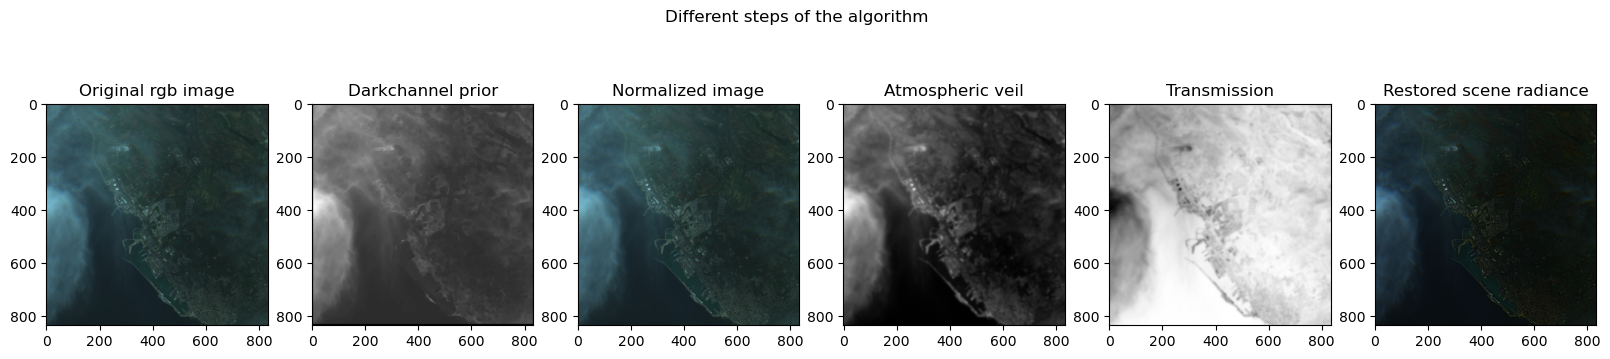

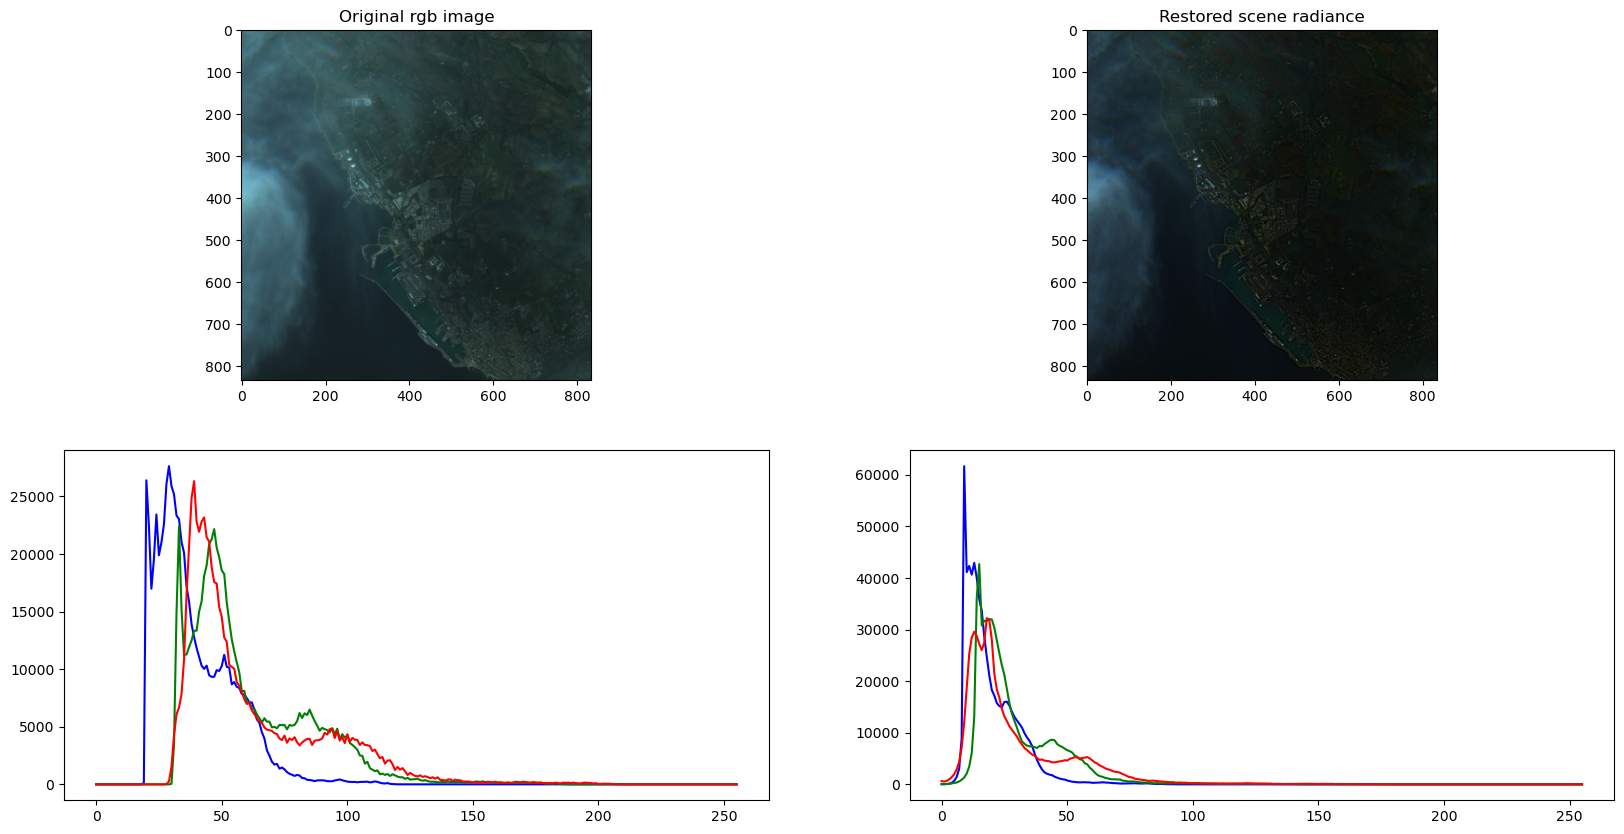

In [3]:
img_name = "Italie_20221017T095919_20221017T100254_T33TTG__orbit_122_DESCENDING_timestamp_1666001351391_cloud_cov_22.606793"
fp = f"../raster/{img_name}.tif"
patch_size = 4
sigma = 3
t0 = 0.3
k = 1.2

# Import array from raster (tif) file
with rasterio.open(fp) as src:
    img = src.read()
# Set 0 values to nan to ignore them afterwards
img = np.where(img==0, np.nan, img)
# Transpose to get an (.,.,10) image with rgb bands
img = np.moveaxis(img, source=0, destination=-1)
print(img.shape)
# Extract rgb bands
rgb = img[:,:,[2,1,0]]

# Normalize bands
rgb = rgb/np.nanmax(rgb, axis=(0,1))

# Plot steps of the algorithm
plot_steps(rgb, patch_size, sigma, t0, k)
# Plot the image vs its restored radiance
plot_comparison(rgb, patch_size, sigma, t0, k)

Tests on the paper figures

(628, 832, 3) (624, 828, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[249 253 253]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


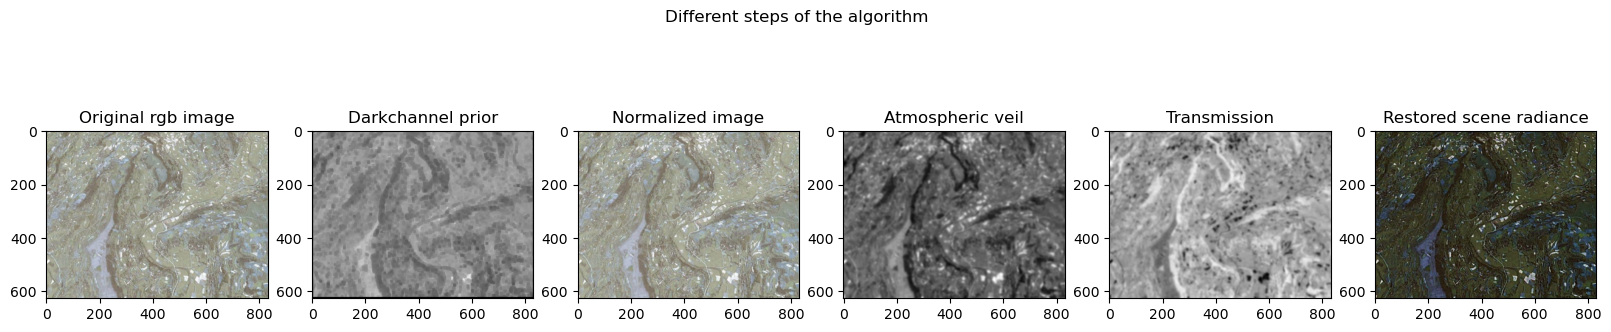

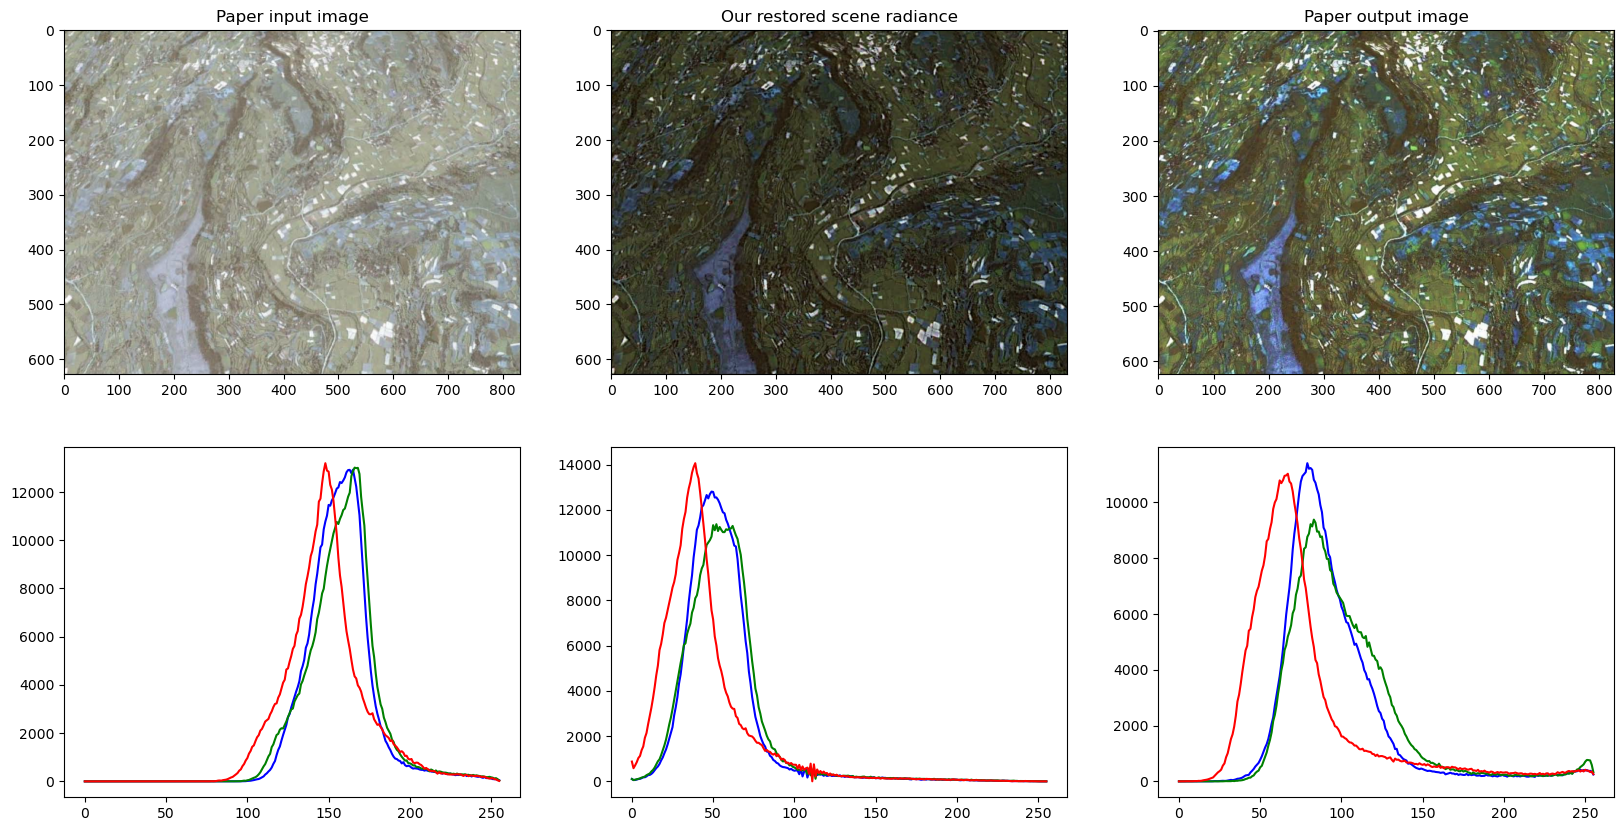

In [16]:
nb = 1

img_name = f"../paper_images/fig_{nb}_input.png"
out_name = f"../paper_images/fig_{nb}_output.png"

patch_size = 4
sigma = 3
t0 = 0.2
k = 0.8

img = cv2.imread(img_name)
out = cv2.imread(out_name)
print(img.shape, out.shape)
# # Plot steps of the algorithm
plot_steps(img, patch_size, sigma, t0, k)

# Compute restored radiance
J = dehazing(img, patch_size, sigma, t0, k)
# Normalization
J = J/np.nanmax(J, axis=(0,1))

# Print original image vs result
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes[0,0].imshow(img)
axes[0,0].set_title("Paper input image")
axes[0,1].imshow(J)
axes[0,1].set_title("Our restored scene radiance")
axes[0,2].imshow(out)
axes[0,2].set_title("Paper output image")

color = ('b','g','r')

for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    histJ = cv2.calcHist([(J*255).astype(np.uint16)],[i],None,[256],[0,256])
    histo = cv2.calcHist([out],[i],None,[256],[0,256])
    axes[1,0].plot(histr,color = col)
    axes[1,1].plot(histJ,color = col)
    axes[1,2].plot(histo,color = col)



More tests on rasters and comparison with non hazy shots at close dates

(1011, 1042, 11)
67548
(1011, 1042, 11)
[0.57870968 0.5799701  0.58367854]


C:\Users\Louis\AppData\Local\Temp\ipykernel_17992\346163958.py:212: RuntimeWarning: invalid value encountered in cast
  histr2 = cv2.calcHist([(img2*255).astype(np.uint16)],[i],None,[256],[0,256])


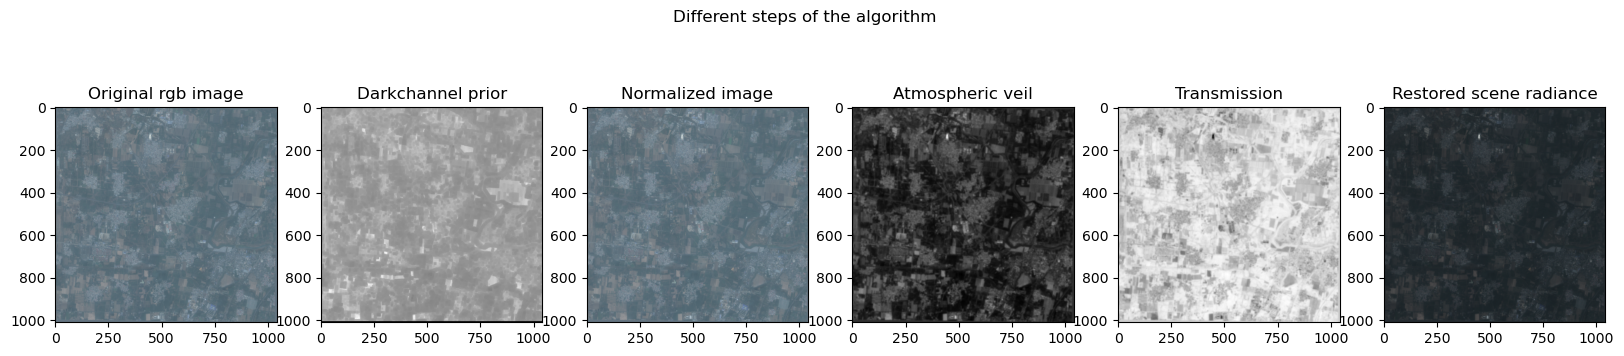

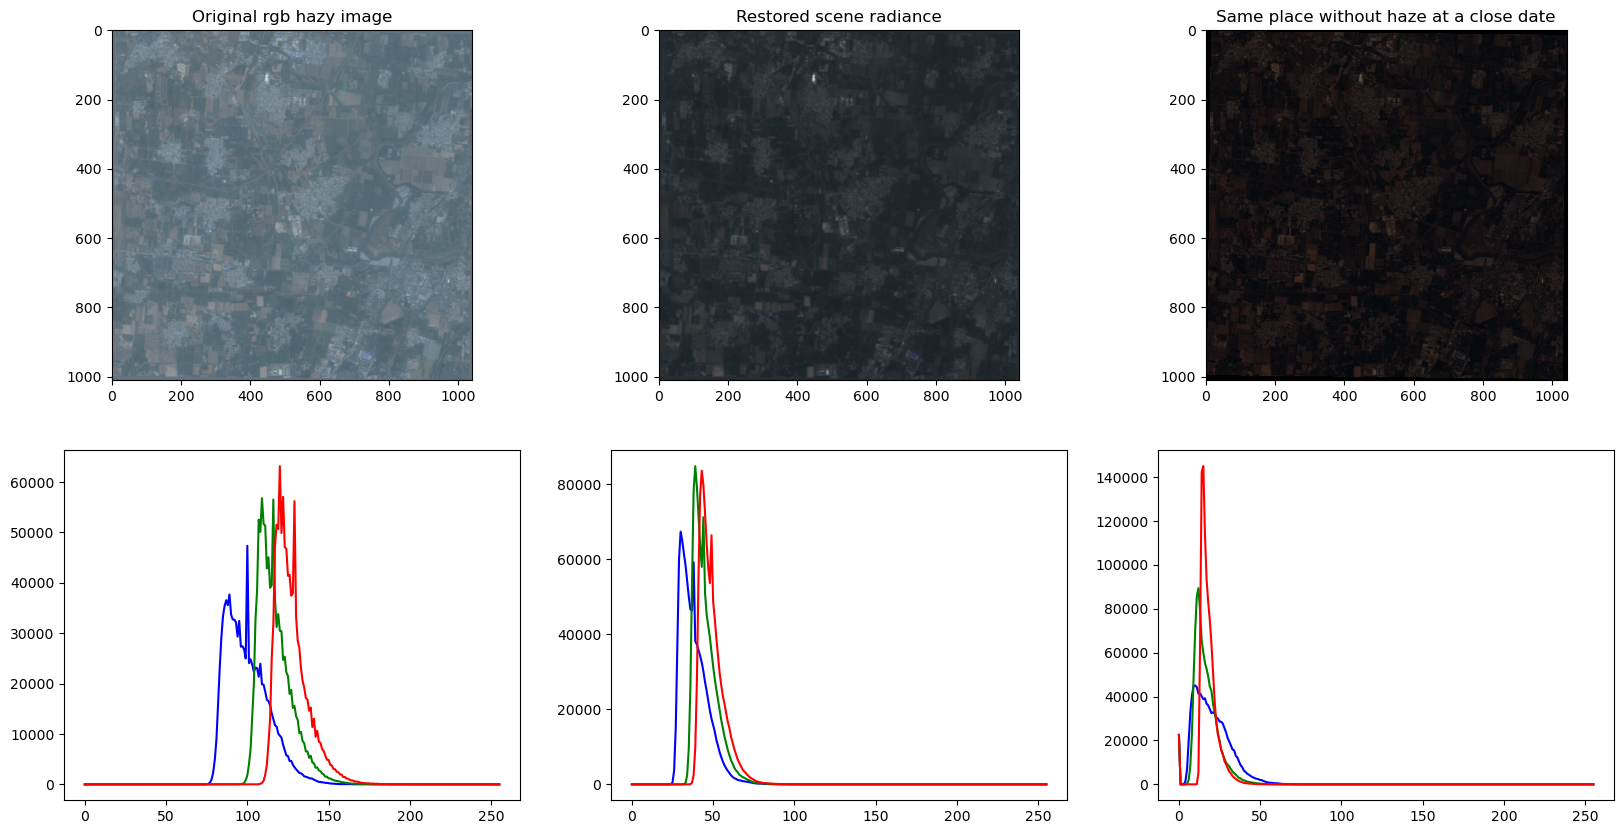

In [13]:
# Plateau de Saclay
# hazy_img = f"../raster/Saclay_20221022T105009_20221022T105642_T31UDP__orbit_51_DESCENDING_timestamp_1666436262305_cloud_cov_21.781307.tif"
# clean_img = f"../raster/Saclay_20221101T105109_20221101T105109_T31UDQ__orbit_51_DESCENDING_timestamp_1667300246568_cloud_cov_4.314537.tif"

# Plateau de Saclay avec nuages
# hazy_img = f"../raster/Saclay_20221116T105321_20221116T105603_T31UDP__orbit_51_DESCENDING_timestamp_1668596265022_cloud_cov_99.095798.tif"
# clean_img = f"../raster/Saclay_20221119T110341_20221119T110339_T31UDP__orbit_94_DESCENDING_timestamp_1668856060288_cloud_cov_32.909733.tif"

# Beijing
hazy_img = f"../raster/Beijing_20221014T030659_20221014T030830_T50SMJ__orbit_75_DESCENDING_timestamp_1665717417269_cloud_cov_0.435052.tif"
clean_img = f"../raster/Beijing_20221019T030731_20221019T031517_T50SMJ__orbit_75_DESCENDING_timestamp_1666149420870_cloud_cov_0.019256.tif"

patch_size = 4
sigma = 2
t0 = 0.2
k = 0.4


# Import array from raster (tif) file
with rasterio.open(hazy_img) as src:
    hazy_img = src.read()
# Set 0 values to nan to ignore them afterwards
hazy_img = np.where(hazy_img==0, np.nan, hazy_img)
# Transpose to get an (.,.,10) image with rgb bands
hazy_img = np.moveaxis(hazy_img, source=0, destination=-1)
print(hazy_img.shape)
# Extract rgb bands
rgb = hazy_img[:,:,[2,1,0]]
print(np.isnan(rgb).sum())
rgb[np.isnan(rgb)] = np.nanmean(rgb)
# Normalize bands
rgb = rgb/np.nanmax(rgb, axis=(0,1))


# Import array from raster (tif) file
with rasterio.open(clean_img) as src:
    clean_img = src.read()
# Set 0 values to nan to ignore them afterwards
clean_img = np.where(clean_img==0, np.nan, clean_img)
# Transpose to get an (.,.,10) image with rgb bands
clean_img = np.moveaxis(clean_img, source=0, destination=-1)
print(clean_img.shape)
# Extract rgb bands
rgb2 = clean_img[:,:,[2,1,0]]

# Normalize bands
rgb2 = (rgb2-np.nanmin(rgb2, axis=(0,1)))/(np.nanmax(rgb2, axis=(0,1))-np.nanmin(rgb2, axis=(0,1)))


# Plot steps of the algorithm
plot_steps(rgb, patch_size, sigma, t0, k)
# Plot the image vs its restored radiance
plot_comparison2(rgb, rgb2, patch_size, sigma, t0, k)
